In [ ]:
# -*- coding: utf-8 -*-
"""
print(Created on Wed Apr 13 07:10:38 2020)

@author: willem van der Schans
"""


In [2]:

import time
import random
start_time = time.time()
random.seed(123)

import pandas as pd #Data Processing
import numpy as np # Analytics
np.random.seed(seed=123)
import matplotlib.pyplot as plt #Plots
import seaborn as sns #Plots
import warnings
from scipy import stats
from scipy.stats import norm, skew
#from numba import jit, cuda 


# Set seaborn settings
color = sns.color_palette("bright")
#plt.style.use('dark_background')
#sns.set.style('darkgrid')

def ingore_warn(*args, **kwargs):
    pass
warnings.warn = ingore_warn #Ignore warnings

#pd.set_option('display.max_rows', 15)

# Import Data

I uploaded the data to my github so the code works on any computer that runs python 3

In [3]:
test = pd.read_excel("https://github.com/Kydoimos97/FINAN6500DATA/raw/master/data/SBA_test_data.xlsx")
train = pd.read_excel("https://github.com/Kydoimos97/FINAN6500DATA/raw/master/data/SBA_training_data.xlsx")
codebook = pd.read_csv("https://github.com/Kydoimos97/FINAN6500DATA/raw/master/data/Variables.csv")

# Codebook

In [4]:

codebook.head(codebook.shape[0])

,Variable name,Data type,Description of variable
0,LoanNr_ChkDgt,Text,Identifier – Primary key
1,Name,Text,Borrower name
2,City,Text,Borrower city
3,State,Text,Borrower state
4,Zip,Text,Borrower zip code
5,Bank,Text,Bank name
6,BankState,Text,Bank state
7,NAICS,Text,North American industry classification system ...
8,ApprovalDate,Date/Time,Date SBA commitment issued
9,ApprovalFY,Text,Fiscal year of commitment


# Exploratory Analysis and Data Cleaning

## Train

In [5]:
print(train.head(10))
print(list(train.columns))
print(format(train.shape))

   LoanNr_ChkDgt                            Name            City State    Zip  \
0     1000014003                  ABC HOBBYCRAFT      EVANSVILLE    IN  47711   
1     1000024006     LANDMARK BAR & GRILLE (THE)       NEW PARIS    IN  46526   
2     1000034009           WHITLOCK DDS, TODD M.     BLOOMINGTON    IN  47401   
3     1000044001   BIG BUCKS PAWN & JEWELRY, LLC    BROKEN ARROW    OK  74012   
4     1000054004     ANASTASIA CONFECTIONS, INC.         ORLANDO    FL  32801   
5     1000084002  B&T SCREW MACHINE COMPANY, INC      PLAINVILLE    CT   6062   
6     1000093009   MIDDLE ATLANTIC SPORTS CO INC           UNION    NJ   7083   
7     1000094005                 WEAVER PRODUCTS     SUMMERFIELD    FL  34491   
8     1000104006                TURTLE BEACH INN  PORT SAINT JOE    FL  32456   
9     1000124001         INTEXT BUILDING SYS LLC     GLASTONBURY    CT   6073   

                            Bank BankState   NAICS ApprovalDate  ApprovalFY  \
0               FIFTH THIRD B

### Missing Values

                  Sum of Missing
ChgOffDate                  8053
MIS_Status                    21
DisbursementDate              16
Bank                           6
BankState                      6
Name                           4
RevLineCr                      1


Text(0.5, 0, 'Features')

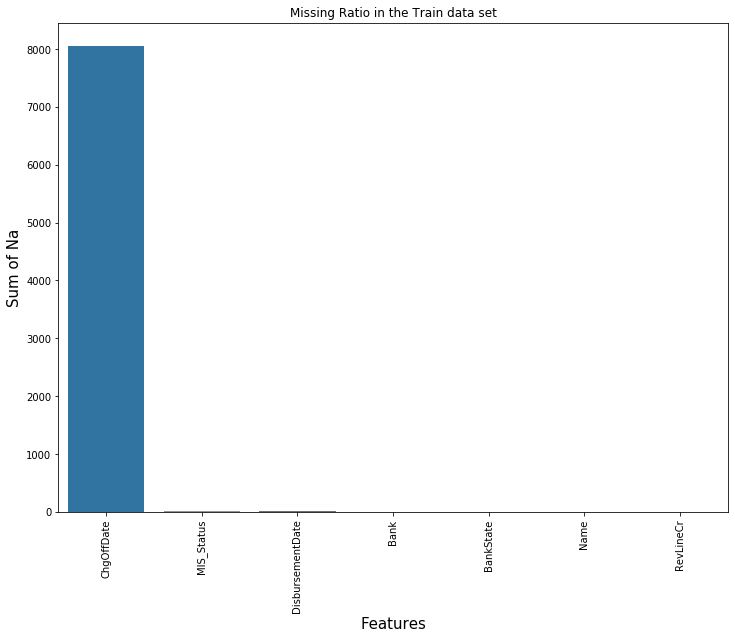

In [6]:
# Missing Values
trainnull = train.isnull().sum()
trainnulldf = trainnull.to_frame().T
trainnulldf = trainnulldf.transpose()
trainnulldf.columns = ['Sum of Missing']
trainnulldf = trainnulldf.drop(trainnulldf[(trainnulldf['Sum of Missing']==0)].index).sort_values(by=['Sum of Missing'], ascending=False)  

print(trainnulldf)    

plt.subplots(figsize=(12,9))
sns.barplot(x=trainnulldf.index, y=trainnulldf['Sum of Missing'])
plt.xticks(rotation='90')
plt.title('Missing Ratio in the Train data set')
plt.ylabel('Sum of Na', fontsize=15)
plt.xlabel('Features', fontsize=15)

After carefull consideration and exploration of the train data set these are the sets that will be taken to clean the data. All changes made are according to the codebook, If the data does not reflect the codebook entries or description it is deemed an error and therefore has to be cleaned.

### Na imputation

In [7]:
print(train['RevLineCr'].value_counts())

for i in train.index:
    if train.iloc[i,train.columns.get_loc('RevLineCr')] != "Y":
        train.at[i, 'RevLineCr'] = "N"
    else:
        train.at[i, 'RevLineCr'] = "Y"
        
print(train['RevLineCr'].value_counts())

N    4344
Y    3546
0    1688
T     419
,       1
`       1
Name: RevLineCr, dtype: int64
N    6454
Y    3546
Name: RevLineCr, dtype: int64


In [8]:
print(train['LowDoc'].value_counts())

for i in train.index:
    if train.iloc[i,train.columns.get_loc('LowDoc')] != "Y":
        train.at[i, 'LowDoc'] = "N"
    else:
        train.at[i, 'LowDoc'] = "Y"
        
print(train['LowDoc'].value_counts())

N    9046
Y     953
C       1
Name: LowDoc, dtype: int64
N    9047
Y     953
Name: LowDoc, dtype: int64


In [9]:
train['ChgOffDate'] = train['ChgOffDate'].fillna(0)

for i in train.index:
    if train.iloc[i,train.columns.get_loc('ChgOffDate')] != 0:
        train.at[i, 'ChgOffDate'] = 1
    else:
        train.at[i, 'ChgOffDate'] = 0
        
print(train['ChgOffDate'].value_counts())

0    8053
1    1947
Name: ChgOffDate, dtype: int64


In [10]:
print(train['FranchiseCode'].value_counts())

for i in train.index:
    if train.iloc[i,train.columns.get_loc('FranchiseCode')] > 1:
        train.at[i, 'FranchiseCode'] = 1
    else:
        train.at[i, 'FranchiseCode'] = 0
        
print(train['FranchiseCode'].value_counts())

1        9434
0         125
78760      23
50564      16
68020      14
         ... 
8047        1
8015        1
9800        1
30210       1
75985       1
Name: FranchiseCode, Length: 250, dtype: int64
0    9559
1     441
Name: FranchiseCode, dtype: int64


In [11]:
train.drop(columns=['LoanNr_ChkDgt', 'Name'], inplace=True)


train.drop(columns=['NAICS'], inplace=True)


train.dropna(subset=['Bank'], inplace=True)
train.dropna(subset=['BankState'], inplace=True)


train.drop(columns=['BalanceGross'], inplace=True)


train.dropna(subset=['MIS_Status'], inplace=True)


train.drop(columns=['City'], inplace=True)
train.drop(columns=['Zip'], inplace=True)


train.drop(columns=['ApprovalDate'], inplace=True)
train.drop(columns=['DisbursementDate'], inplace=True)

print(format(train.shape))

(9977, 19)


In [12]:
# Missing Values
trainnull = train.isnull().sum()
trainnulldf = trainnull.to_frame().T
trainnulldf = trainnulldf.transpose()
trainnulldf.columns = ['Sum of Missing']
trainnulldf = trainnulldf.drop(trainnulldf[(trainnulldf['Sum of Missing']==0)].index).sort_values(by=['Sum of Missing'], ascending=False)  

print(trainnulldf) 

Empty DataFrame
Columns: [Sum of Missing]
Index: []


## Test

In [13]:
print(test.head(10))
print(list(test.columns))
print(format(test.shape))

   LoanNr_ChkDgt                            Name           City State    Zip  \
0     1069795008                 Maple Dye, Inc.    LOS ANGELES    CA  90005   
1     1069835007       Resource Solutions, Corp.       COLUMBUS    WI  53925   
2     1069855002                Shadow Horse LLC  BRADLEY BEACH    NJ   7720   
3     1069865005  Cold Mountain Company dba Robe        HOUSTON    TX  77098   
4     1069875008  Double K Equipment Sales, Inc.         Minden    LA  71055   
5     1069884004     TUMBLEWEED GYMNASTICS, INC.     FORT WORTH    TX  76112   
6     1069885000        M.D. Science Lab, L.L.C.  POMPANO BEACH    FL  33060   
7     1069895003           Butthead Covers, Inc.        GILBERT    AZ  85296   
8     1069905004   Sunrise Interior Specialists,        PHOENIX    AZ  85009   
9     1069914000                    I AM STAMPIN          UNITY    WI  54488   

                             Bank BankState   NAICS ApprovalDate  ApprovalFY  \
0      BANK OF AMERICA NATL ASSOC      

### Missing Values

                  Sum of Missing
ChgOffDate                  1000
MIS_Status                  1000
ChgOffPrinGr                1000
DisbursementDate               2
Bank                           1
BankState                      1
RevLineCr                      1


Text(0.5, 0, 'Features')

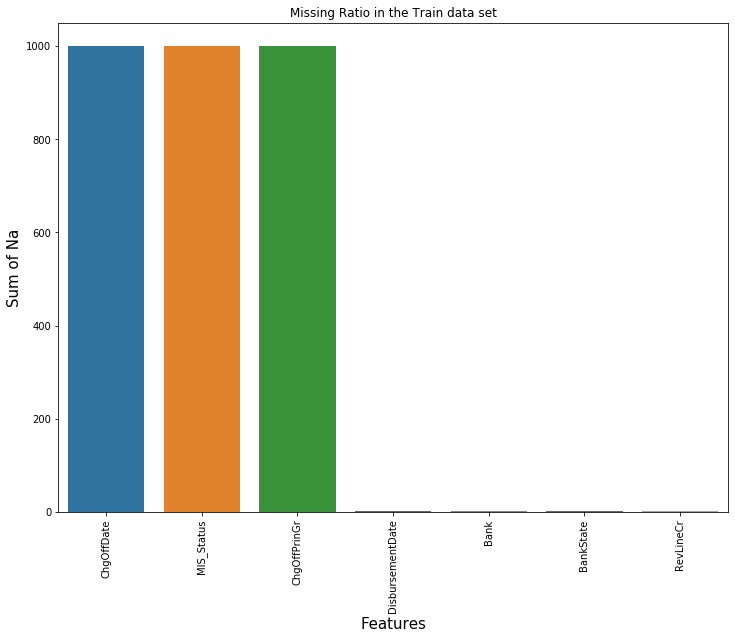

In [14]:
testnull = test.isnull().sum()
testnulldf = testnull.to_frame().T
testnulldf = testnulldf.transpose()
testnulldf.columns = ['Sum of Missing']
testnulldf = testnulldf.drop(testnulldf[(testnulldf['Sum of Missing']==0)].index).sort_values(by=['Sum of Missing'], ascending=False)  

print(testnulldf)    

plt.subplots(figsize=(12,9))
sns.barplot(x=testnulldf.index, y=testnulldf['Sum of Missing'])
plt.xticks(rotation='90')
plt.title('Missing Ratio in the Train data set')
plt.ylabel('Sum of Na', fontsize=15)
plt.xlabel('Features', fontsize=15)

Here I will do the same imputation and transformation I have done for the train data set with the exception of the target variables. 

In [15]:
print(test['RevLineCr'].value_counts())

for i in test.index:
    if test.iloc[i,test.columns.get_loc('RevLineCr')] != "Y":
        test.at[i, 'RevLineCr'] = "N"
    else:
        test.at[i, 'RevLineCr'] = "Y"
        
print(test['RevLineCr'].value_counts())

N    494
Y    399
0     67
T     39
Name: RevLineCr, dtype: int64
N    601
Y    399
Name: RevLineCr, dtype: int64


In [16]:

print(test['LowDoc'].value_counts())

for i in test.index:
    if test.iloc[i,test.columns.get_loc('LowDoc')] != "Y":
        test.at[i, 'LowDoc'] = "N"
    else:
        test.at[i, 'LowDoc'] = "Y"
        
print(test['LowDoc'].value_counts())

N    921
Y     79
Name: LowDoc, dtype: int64
N    921
Y     79
Name: LowDoc, dtype: int64


In [17]:
print(test['FranchiseCode'].value_counts())

for i in test.index:
    if test.iloc[i,test.columns.get_loc('FranchiseCode')] > 1:
        test.at[i, 'FranchiseCode'] = 1
    else:
        test.at[i, 'FranchiseCode'] = 0
        
print(test['FranchiseCode'].value_counts())

1        949
0         18
78760      4
72590      2
49952      2
24850      2
50564      1
53250      1
33170      1
84025      1
64650      1
67750      1
60590      1
21780      1
79140      1
73000      1
73675      1
53650      1
64975      1
46561      1
52707      1
1560       1
5725       1
50860      1
17100      1
46875      1
73525      1
52000      1
45505      1
Name: FranchiseCode, dtype: int64
0    967
1     33
Name: FranchiseCode, dtype: int64


In [18]:

test.drop(columns=['LoanNr_ChkDgt', 'Name'], inplace=True)


test.drop(columns=['NAICS'], inplace=True)


test.dropna(subset=['Bank'], inplace=True)
test.dropna(subset=['BankState'], inplace=True)


test.drop(columns=['BalanceGross'], inplace=True)


test.drop(columns=['City'], inplace=True)
test.drop(columns=['Zip'], inplace=True)


test.drop(columns=['ApprovalDate'], inplace=True)
test.drop(columns=['DisbursementDate'], inplace=True)

print(format(test.shape))

(999, 19)


              Sum of Missing
ChgOffDate               999
MIS_Status               999
ChgOffPrinGr             999


Text(0.5, 0, 'Features')

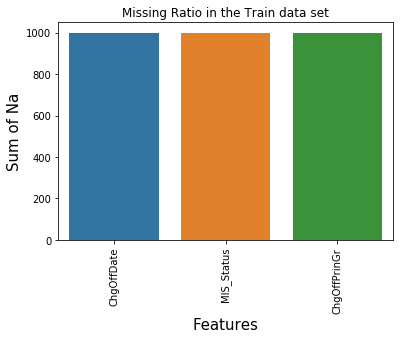

In [19]:
# Missing Values
testnull = test.isnull().sum()
testnulldf = testnull.to_frame().T
testnulldf = testnulldf.transpose()
testnulldf.columns = ['Sum of Missing']
testnulldf = testnulldf.drop(testnulldf[(testnulldf['Sum of Missing']==0)].index).sort_values(by=['Sum of Missing'], ascending=False)  

print(testnulldf)    

sns.barplot(x=testnulldf.index, y=testnulldf['Sum of Missing'])
plt.xticks(rotation='90')
plt.title('Missing Ratio in the Train data set')
plt.ylabel('Sum of Na', fontsize=15)
plt.xlabel('Features', fontsize=15)

## Comparison of Data Sets after Cleaning

here I compare columns to make sure that the data sets are identical in its variables, if they are not algorithms will throw errors or warnings.

In [20]:
traincol = list(train.columns)
testcol = list(test.columns)

def Diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

print("Column difference:",Diff(traincol,testcol))

print("Train Dimensions:", format(train.shape))
print("Test Dimensions:", format(test.shape))

Column difference: []
Train Dimensions: (9977, 19)
Test Dimensions: (999, 19)


As we can see there are some entries lost however this method is more robust then any reasonable form of imputation especially regarding the missing bank entries. Guessing what bank was the bank that issues these loans is risky and not statistically robust. The sample size of what is left is sufficient to perform predictive analysis.

## Merge Data Sets

Data sets will be merged for easier label and one-hot encoding, together with skewness analysis. I do this now since when the NA's were imputed a number of rows were removed which would change the shape of the data sets making it hard to find out where to cut them apart later.

In [21]:
# Save Rowcount of Data set to seperate later
ntrain = train.shape[0]
ntest = test.shape[0]

#Save Target Variables
y_ChgOffDate = train.ChgOffDate.values


y_MIS_Status = train.MIS_Status.values


y_ChgOffPrinGr = train.ChgOffPrinGr.values


# Merge Data sets.
alldata = pd.concat((train, test)).reset_index(drop=True)
alldata.drop(['ChgOffDate', 'MIS_Status', 'ChgOffPrinGr'], axis=1, inplace=True)
print(format(alldata.shape))


(10976, 16)


## WebScraping

For webscraping I downloaded a data set of the internet of past recession periods in the US. I then created a dictionary out the years and included them in a new column based on ApprovedFY. This column is a binominal variable called recession. For conservation purposes I also uploaded this data to my GITHUB and added a row to be able to call this data, however this is currently not utilized.

The Data Comes from the St. Louid Federal Reserve Bank more about them here: https://research.stlouisfed.org/about.html

In [22]:
recession = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=off&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=JHDUSRGDPBR&scale=left&cosd=1967-10-01&coed=2019-07-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2020-04-15&revision_date=2020-04-15&nd=1967-10-01")
#recession = pd.read_csv("https://github.com/Kydoimos97/FINAN6500DATA/raw/master/data/JHDUSRGDPBR.csv")

recession.rename(columns = {"JHDUSRGDPBR" : "Recession", "DATE" : "Date"}, inplace=True)

recession['Date'] = pd.to_datetime(recession['Date'])
recession['Recession'] = recession['Recession'].astype('int64').astype(dtype="category")

recession['Year'] = recession['Date'].dt.year


In [23]:
recession = recession.reset_index()
recession = recession.pivot(index='index', columns='Year', values='Recession')
recession = recession.mode(axis = 0, dropna=True)
recession = recession.drop(index=recession.index.difference([0]))

keys = tuple(recession.columns)
values = tuple(recession.to_numpy()[0])

rename_dict = dict(zip(keys, values))

In [24]:
alldata['Recession'] = alldata['ApprovalFY']
alldata['Recession'] = alldata['Recession'].replace(rename_dict)
alldata['Recession'].fillna(0, inplace=True)

print(alldata['Recession'].value_counts())

0    10842
1      134
Name: Recession, dtype: int64


## Further Cleaning of AllData

In [25]:
y_MIS_Status = pd.DataFrame(y_MIS_Status)

#Number 4  
print(y_MIS_Status[0].value_counts())

for i in y_MIS_Status.index:
    if y_MIS_Status.iloc[i,y_MIS_Status.columns.get_loc(0)] != "P I F":
        y_MIS_Status.at[i, 0] = 1
    else:
        y_MIS_Status.at[i, 0] = 0
        
print(y_MIS_Status[0].value_counts())

y_MIS_Status = y_MIS_Status.to_numpy()

P I F     8118
CHGOFF    1859
Name: 0, dtype: int64
0    8118
1    1859
Name: 0, dtype: int64


In [26]:
# Give Correct Data Label to target variables
y_ChgOffDate=y_ChgOffDate.astype('int')
y_MIS_Status = y_MIS_Status.astype('int')
y_ChgOffPrinGr = y_ChgOffPrinGr.astype('int')

# Feature Engineering

## Target Variable

For the target variable I will use CHGOffDate with classification algortihms. I chose this variable because when cleaning the data set I changed more about MIS_Status then I did to ChgOffDate therefore making ChgOffDate a more relibable predictor. Also after trying over and over again to improve regression scores on ChgOffPrinGr I ended up with an error of around 50k which I deemed unreliable and therefore dropped these efforts.

[8037, 1940]


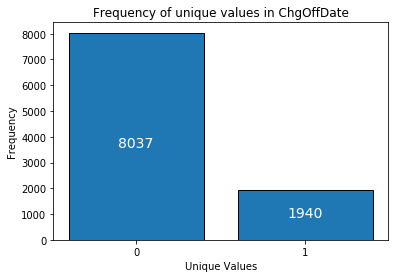

In [27]:
import collections

c = list(y_ChgOffDate)
name = str(c).split()

c = collections.Counter(c)
c = sorted(c.items())
y_ChgOffDate_num = [i[0] for i in c]
y_ChgOffDate_names = [name[i[0]-1] for i in c]
freq = [i[1] for i in c]

print(freq)

f, ax = plt.subplots()

plt.bar(y_ChgOffDate_num, freq, edgecolor='black')
plt.title("Frequency of unique values in ChgOffDate")
plt.xlabel("Unique Values")
plt.ylabel("Frequency")
ax.set_xticks(range(0, 2))
ax.set_xticklabels(range(0,2))
for x,y in zip(y_ChgOffDate_num,freq):

    label = y

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-(y/70)), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center 
                 color='w', size=14)

plt.show()


## Correlation Matrix

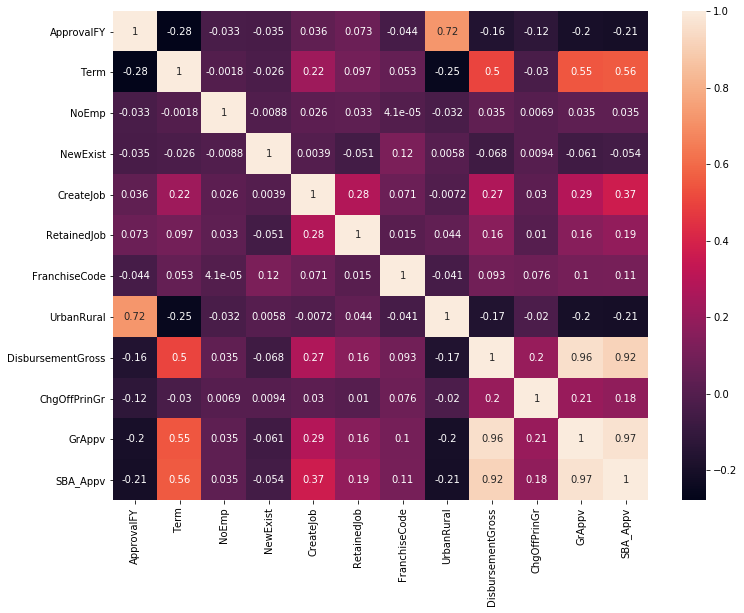

In [28]:
correlation = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True)

## Label Encoding

Bank is label encoded since one-hot encoding it will create a data set that is so big it hinders performance to an extreme degree additionally one-hot encoding this variable does not improve performance of the algorithms. 

In [29]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder() 
lbl.fit(list(alldata['Bank'].values)) 
alldata['Bank'] = lbl.transform(list(alldata['Bank'].values))

# shape        
print(format(alldata.shape))

(10976, 17)


## Skewness and Box-Cox Transformations

In [30]:
numeric_feats = alldata.dtypes[alldata.dtypes == "int64"].index

# Check the skew of all numerical features
skewed_feats = alldata[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features before transformations: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(21)


Skew in numerical features before transformations: 



,Skew
NoEmp,70.913397
RetainedJob,16.645331
CreateJob,14.712354
Recession,8.883851
SBA_Appv,5.030664
DisbursementGross,4.700242
GrAppv,4.611379
FranchiseCode,4.494580
Term,1.786785
NewExist,0.722700


In [31]:
skewness = skewness[abs(skewness) > .75]
skewness.dropna(inplace=True)

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15 #Regularly Picked Value
for feat in skewed_features:
    alldata[feat] = boxcox1p(alldata[feat], lam)
    
numeric_feats = alldata.dtypes[alldata.dtypes == "int64"].index

# Check the skew of all numerical features
skewed_feats = alldata[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features after transformations: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(21)


Skew in numerical features after transformations: 



,Skew
NewExist,0.722700
Bank,0.416096
UrbanRural,0.261759


## One-hot Encoding

In [32]:
print("Variables that will be one-hot encoded are:", list(alldata.dtypes[alldata.dtypes == "object"].index))
print(alldata.shape)

Variables that will be one-hot encoded are: ['State', 'BankState', 'RevLineCr', 'LowDoc']
(10976, 17)


In [33]:
alldata = pd.get_dummies(alldata)
print(alldata.shape)

(10976, 120)


## Recreate Train and Test Data Sets

In [34]:
train = alldata[:ntrain]
test = alldata[ntrain:]

## Data Scaling

I looked into data scaling to help with an ill-condition matrix warning thrown by the KRR algorithm. While I normally would scale my data, this would make it extremely hard to do point 8 effectively. Additionally I am not using any Kernel tricks anymore so this is less of a problem now.

In [35]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(train)

#train = scaler.transform(train)
#test = scaler.transform(test)

#train = pd.DataFrame(train)
#test = pd.DataFrame(test)

## Hold-Out evaluation 

I do this since the correct answers aren't available and I want to make sure my algorithms perform. By utilizing cross-validation and Hold-Out evaluation I can be confident about my results. This also allows me to easily see my in-sample accuracy which means I can combat over-fitting more easily.

In [36]:
from sklearn.model_selection import train_test_split

HO_X_train1, HO_X_test1, HO_y_train_CL, HO_y_test_CL = train_test_split(train, y_ChgOffDate, test_size=0.15)

HO_X_train2, HO_X_test2, HO_y_train_CO, HO_y_test_CO = train_test_split(train, y_ChgOffPrinGr, test_size=0.15)

## Cross-Validation

The Main metric I will use to evaulate my alogrithms is the accuracy measure.

In [37]:
#Validation function
n_folds = 5

def acc_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    acc= cross_val_score(model, train.values, y_train, scoring='accuracy', cv = kf)
    return(acc)

# Machine Learning

## Load Algorithms

In [38]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

# XGBoost
import xgboost as xgb

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#Support Vector Classification.
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

#Create Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score

## Set Options

#### Support Vector Classification
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

#### K Neighbors Classifier
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

#### Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### XGBoost
https://xgboost.readthedocs.io/en/latest/parameter.html

In [39]:
model_SVC = SVC(cache_size = 8000)

model_KNN = KNeighborsClassifier(n_neighbors=5, weights='distance',algorithm = 'auto', n_jobs = -1)

model_RFC = RandomForestClassifier(n_jobs = -1)


model_xgb = xgb.XGBClassifier(colsample_bytree=0.5, gamma=0.5, 
                             learning_rate=0.1, max_depth=5, 
                             min_child_weight=1, n_estimators=350,
                             reg_alpha=0.25, reg_lambda = 0.5,
                             subsample=0.5, silent=1, scale_pos_weight = 1,
                             random_state =123, nthread = -1)

model_LGR = LogisticRegression(max_iter=10000)

model_DTC = DecisionTreeClassifier(max_depth=10, max_features = None, min_samples_leaf = 40)

y_train = y_ChgOffDate #Target Variable

In [40]:
# Initizialise List to save results
modelnames = ['Random forest Classification', 'Logistic Regression', 'Decision Trees Classifier', 'Support Vector Classification', 'K-Neighbors Classification', 'XGBoost Classification']
CV_scores = []
OS_HO_scores = []
IS_HO_scores = []

## Find Accuracy Scores by Validation

### Random forest Classifcation

In [41]:
score_RFC = acc_cv(model_RFC)
print("Random Forest Cross-Val Accuracy score: {:.4f} ({:.4f})\n".format(score_RFC.mean(), score_RFC.std()))
CV_scores.append(score_RFC.mean())

#####Hold-Out#####
model_RFC.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

RFC_train_pred = model_RFC.predict(HO_X_train1) #InSample Holdout RMSE

RFC_pred_HO = model_RFC.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, RFC_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_insample_RFC_score = accuracy_score(HO_y_train_CL, RFC_train_pred, normalize=True, sample_weight=None)
IS_HO_scores.append(hold_out_insample_RFC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_insample_RFC_score))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, RFC_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_outsample_RFC_score = accuracy_score(HO_y_test_CL, RFC_pred_HO, normalize=True, sample_weight=None)
OS_HO_scores.append(hold_out_outsample_RFC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_outsample_RFC_score))

Random Forest Cross-Val Accuracy score: 0.9385 (0.0253)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6826     0  6826
1             0  1654  1654
All        6826  1654  8480
Out-Of-Sample Hold-Out Accuracy = 1.0000


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1196   15  1211
1            74  212   286
All        1270  227  1497
Out-Of-Sample Hold-Out Accuracy = 0.9405


### Logistic Regression

In [42]:
score_LGR = acc_cv(model_LGR)
print("Logistic Regression Cross-Val Accuracy score: {:.4f} ({:.4f})\n".format(score_LGR.mean(), score_LGR.std()))
CV_scores.append(score_LGR.mean())

#####Hold-Out#####
model_LGR.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

LGR_train_pred = model_LGR.predict(HO_X_train1) #InSample Holdout RMSE

LGR_pred_HO = model_LGR.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, LGR_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_insample_LGR_score = accuracy_score(HO_y_train_CL, LGR_train_pred, normalize=True, sample_weight=None)
IS_HO_scores.append(hold_out_insample_LGR_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_insample_LGR_score))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, LGR_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_outsample_LGR_score = accuracy_score(HO_y_test_CL, LGR_pred_HO, normalize=True, sample_weight=None)
OS_HO_scores.append(hold_out_outsample_LGR_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_outsample_LGR_score))

Logistic Regression Cross-Val Accuracy score: 0.8727 (0.0245)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6625   201  6826
1           782   872  1654
All        7407  1073  8480
Out-Of-Sample Hold-Out Accuracy = 0.8841


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1174   37  1211
1           141  145   286
All        1315  182  1497
Out-Of-Sample Hold-Out Accuracy = 0.8811


### Decision Trees

In [43]:
score_DTC = acc_cv(model_DTC)
print("Decision Trees Cross-Val Accuracy score: {:.4f} ({:.4f})\n".format(score_DTC.mean(), score_DTC.std()))
CV_scores.append(score_DTC.mean())

#####Hold-Out#####
model_DTC.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

DTC_train_pred = model_DTC.predict(HO_X_train1) #InSample Holdout RMSE

DTC_pred_HO = model_DTC.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, DTC_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_insample_DTC_score = accuracy_score(HO_y_train_CL, DTC_train_pred, normalize=True, sample_weight=None)
IS_HO_scores.append(hold_out_insample_DTC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_insample_DTC_score))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, DTC_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_outsample_DTC_score = accuracy_score(HO_y_test_CL, DTC_pred_HO, normalize=True, sample_weight=None)
OS_HO_scores.append(hold_out_outsample_DTC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_outsample_DTC_score))

Decision Trees Cross-Val Accuracy score: 0.9282 (0.0340)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6608   218  6826
1           255  1399  1654
All        6863  1617  8480
Out-Of-Sample Hold-Out Accuracy = 0.9442


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1179   32  1211
1            50  236   286
All        1229  268  1497
Out-Of-Sample Hold-Out Accuracy = 0.9452


### Support Vector Classifcation

In [44]:
#####Cross-Validation#####
score_SVC = acc_cv(model_SVC)
print("SVC Accuracy score: {:.4f} ({:.4f})\n".format(score_SVC.mean(), score_SVC.std()))
CV_scores.append(score_SVC.mean())

#####Hold-Out#####
model_SVC.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

SVC_train_pred = model_SVC.predict(HO_X_train1) #InSample Holdout RMSE

SVC_pred_HO = model_SVC.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, SVC_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_insample_SVC_score = accuracy_score(HO_y_train_CL, SVC_train_pred, normalize=True, sample_weight=None)
IS_HO_scores.append(hold_out_insample_SVC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_insample_SVC_score))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, SVC_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_outsample_SVC_score = accuracy_score(HO_y_test_CL, SVC_pred_HO, normalize=True, sample_weight=None)
OS_HO_scores.append(hold_out_outsample_SVC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_outsample_SVC_score))

SVC Accuracy score: 0.8056 (0.0000)



########In-Sample Hold-Out########
Predicted     0   All
Actual               
0          6826  6826
1          1654  1654
All        8480  8480
Out-Of-Sample Hold-Out Accuracy = 0.8050


########Out-Of-Sample Hold-Out########
Predicted     0   All
Actual               
0          1211  1211
1           286   286
All        1497  1497
Out-Of-Sample Hold-Out Accuracy = 0.8090


### K-Neighbours Classifcation

In [45]:
score_KNN = acc_cv(model_KNN)
print("KNN Accuracy score: {:.4f} ({:.4f})\n".format(score_KNN.mean(), score_KNN.std()))
CV_scores.append(score_KNN.mean())

#####Hold-Out#####
model_KNN.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

KNN_train_pred = model_KNN.predict(HO_X_train1) #InSample Holdout RMSE

KNN_pred_HO = model_KNN.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, KNN_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_insample_KNN_score = accuracy_score(HO_y_train_CL, KNN_train_pred, normalize=True, sample_weight=None)
IS_HO_scores.append(hold_out_insample_KNN_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_insample_KNN_score))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, KNN_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_outsample_KNN_score = accuracy_score(HO_y_test_CL, KNN_pred_HO, normalize=True, sample_weight=None)
OS_HO_scores.append(hold_out_outsample_KNN_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_outsample_KNN_score))

KNN Accuracy score: 0.8803 (0.0266)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6826     0  6826
1             0  1654  1654
All        6826  1654  8480
Out-Of-Sample Hold-Out Accuracy = 1.0000


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1177   34  1211
1           113  173   286
All        1290  207  1497
Out-Of-Sample Hold-Out Accuracy = 0.9018


### XGBoost Classifcation

In [46]:
score_xgb = acc_cv(model_xgb)
print("Xgboost Accuracy score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))
CV_scores.append(score_xgb.mean())

#####Hold-Out#####
model_xgb.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

xgb_train_pred = model_xgb.predict(HO_X_train1) #InSample Holdout RMSE

xgb_pred_HO = model_xgb.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, xgb_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_insample_xgb_score = accuracy_score(HO_y_train_CL, xgb_train_pred, normalize=True, sample_weight=None)
IS_HO_scores.append(hold_out_insample_xgb_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_insample_xgb_score))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, xgb_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_outsample_xgb_score = accuracy_score(HO_y_test_CL, xgb_pred_HO, normalize=True, sample_weight=None)
OS_HO_scores.append(hold_out_outsample_xgb_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_outsample_xgb_score))

Xgboost Accuracy score: 0.9537 (0.0128)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6797    29  6826
1            73  1581  1654
All        6870  1610  8480
Out-Of-Sample Hold-Out Accuracy = 0.9880


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1186   25  1211
1            47  239   286
All        1233  264  1497
Out-Of-Sample Hold-Out Accuracy = 0.9519


In [47]:
# Create Overview DataFrame
scores_tuples = list(zip(modelnames,CV_scores, OS_HO_scores, IS_HO_scores))
scores_df = pd.DataFrame(scores_tuples, columns=['Model','CV_Score', 'HO_Out-Of-Sample_Score','HO_In-Sample_Score'])
scores_df = scores_df.round(4)
scores_df.sort_values(by=['CV_Score'], inplace=True, ascending=False)
scores_df.reset_index(inplace=True, drop=True)

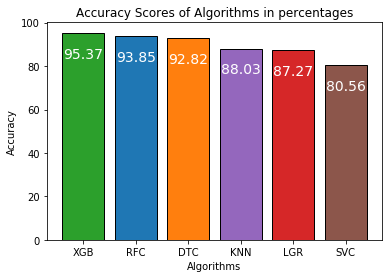

,Model,CV_Score,HO_Out-Of-Sample_Score,HO_In-Sample_Score
0,XGBoost Classification,0.9537,0.9519,0.9880
1,Random forest Classification,0.9385,0.9405,1.0000
2,Decision Trees Classifier,0.9282,0.9452,0.9442
3,K-Neighbors Classification,0.8803,0.9018,1.0000
4,Logistic Regression,0.8727,0.8811,0.8841
5,Support Vector Classification,0.8056,0.8090,0.8050


In [48]:
scores = {'RFC' : score_RFC.mean()*100,
                   'LGR': score_LGR.mean()*100,
                   'DTC': score_DTC.mean()*100,
                   'SVC': score_SVC.mean()*100, 
                   'KNN' : score_KNN.mean()*100, 
                   'XGB' : score_xgb.mean()*100}
scores_sorted = {k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])}

scores_sorted
keys = scores_sorted.keys()
values = scores_sorted.values()

formatted_values = []
for item in values :
    formatted_values.append("%.2f"%item)


barplot = plt.bar(keys, values, edgecolor='black', color=['C2', 'C0', 'C1', 'C4', 'C3', 'C5'])
plt.title("Accuracy Scores of Algorithms in percentages")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
for x,y,z in zip(keys,values,formatted_values):

    label = z

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center 
                 color='w', size=14)

plt.show()

scores_df.head(6)

As we can see XGBoost Classification, Random forest Classification and Decision Trees Classifier have the best scores. They will not be subjected to a grid search to find the most optimal parameters. 

## Grid Search

After speaking to my Professor he notified me about grid searching which Intrigued me. I wanted to learn how to do this and this project seemed like a perfect chance to do so. 

### XGBoost

#### Max_depth and Min_Child Weight

In [49]:
param_test1 = {'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=350, max_depth=6,
 min_child_weight=1, gamma=0.5, subsample=0.5, colsample_bytree=0.8, reg_lambda = 0.5,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test1, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch1.fit(train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 5}, 0.9536953104203395)

In [50]:
# Higher Precision around previously found value
param_test2 = {'max_depth':range(8,9,10),
 'min_child_weight':range(4,5,6)}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=350, max_depth=9,
 min_child_weight=5, gamma=0.5, subsample=0.5, colsample_bytree=0.8, reg_lambda = 0.5,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test2, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch2.fit(train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 8, 'min_child_weight': 4}, 0.9535954615998914)

#### Gamma

In [51]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=350, max_depth=8,
 min_child_weight=4, gamma=0.5, subsample=0.5, colsample_bytree=0.8, reg_lambda = 0.5,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test3, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch3.fit(train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.4}, 0.9543972657093635)

#### SubSample and Colsample_bytree

In [52]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=350, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.5, colsample_bytree=0.8, reg_lambda = 0.5,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test4, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch4.fit(train,y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.8}, 0.9557004736289623)

In [53]:
# Higher Precision around previously found value
param_test5 = {
 'subsample':[i/100.0 for i in range(70,90,5)],
 'colsample_bytree':[i/100.0 for i in range(50,70,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=350, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.5, colsample_bytree=0.8, reg_lambda = 0.5,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test5, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch5.fit(train,y_train)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.8}, 0.9557004736289623)

#### Reg_Alpha

In [54]:
# Higher Precision around previously found value
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=350, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.6, reg_lambda = 0.5,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test6, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch6.fit(train,y_train)
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, 0.9556002230023959)

In [55]:
param_test7 = {
 'reg_alpha':[0,0.0000001, 0.000001, 0.00001, 0.0001, 0.001]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=350, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.6, reg_lambda = .5,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test7, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch7.fit(train,y_train)
gsearch7.best_params_, gsearch7.best_score_

({'reg_alpha': 0}, 0.9557004736289623)

#### Learning Rate

In [56]:
param_test8 = {
 'learning_rate':[i/10.0 for i in range(0,10)]
}
gsearch8 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=350, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.6, reg_lambda = .5, reg_alpha = 0,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test8, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch8.fit(train,y_train)
gsearch8.best_params_, gsearch8.best_score_

({'learning_rate': 0.1}, 0.9557004736289623)

In [57]:
param_test9 = {
 'learning_rate':[i/100 for i in range(0,20)]
}
gsearch9 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=350, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.6, reg_lambda = .5, reg_alpha = 0,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test9, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch9.fit(train,y_train)
gsearch9.best_params_, gsearch9.best_score_

({'learning_rate': 0.08}, 0.956401725757279)

#### n_estimators

In [58]:
param_test10 = {
 'n_estimators': range(100,500,50)
}
gsearch10 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.08, n_estimators=350, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.6, reg_lambda = .5, reg_alpha = 0,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test10, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch10.fit(train,y_train)
gsearch10.best_params_, gsearch10.best_score_

({'n_estimators': 200}, 0.9564017759830439)

In [59]:
param_test11 = {
 'n_estimators': range(160,240,10)
}
gsearch11 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.08, n_estimators=350, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.6, reg_lambda = .5, reg_alpha = 0,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test11, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch11.fit(train,y_train)
gsearch11.best_params_, gsearch11.best_score_

({'n_estimators': 230}, 0.9567025780885079)

#### reg_lambda

In [60]:
param_test12 = {
 'reg_lambda': [i/10 for i in range(0,10)]
}
gsearch12 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.08, n_estimators=230, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.6, reg_lambda = .5, reg_alpha = 0,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test12, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch12.fit(train,y_train)
gsearch12.best_params_, gsearch12.best_score_

({'reg_lambda': 0.5}, 0.9567025780885079)

In [61]:
param_test13 = {
 'reg_lambda': [i/100 for i in range(40,60)]
}
gsearch13 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.08, n_estimators=230, max_depth=8,
 min_child_weight=4, gamma=0.4, subsample=0.8, colsample_bytree=0.6, reg_lambda = .5, reg_alpha = 0,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=123), 
 param_grid = param_test13, scoring='accuracy',n_jobs=6,iid=False, cv=5)
gsearch13.fit(train,y_train)
gsearch13.best_params_, gsearch13.best_score_

({'reg_lambda': 0.41}, 0.9571034801432438)

### Random Forest

#### Max_depth and Min_Child Weight

In [62]:
rfc=RandomForestClassifier(random_state=123, n_jobs = -1)
param_test12 = { 
    'n_estimators': range(100,500,100),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,20,40,80],
    'criterion' :['gini', 'entropy']
}
gsearch12 = GridSearchCV(estimator=rfc, param_grid=param_test12, cv= 5, n_jobs=6, scoring = 'accuracy')
gsearch12.fit(train,y_train)
gsearch12.best_params_, gsearch12.best_score_

({'criterion': 'gini',
  'max_depth': 40,
  'max_features': 'auto',
  'n_estimators': 300},
 0.939664542116815)

In [63]:
rfc=RandomForestClassifier(random_state=123, n_jobs = -1, criterion='gini', max_features = 'auto')
param_test13 = { 
    'n_estimators': range(250,350,10),
    'max_depth' : range(30,60,5),
}
gsearch13 = GridSearchCV(estimator=rfc, param_grid=param_test13, cv= 5, n_jobs=6, scoring = 'accuracy')
gsearch13.fit(train,y_train)
gsearch13.best_params_, gsearch13.best_score_

({'max_depth': 55, 'n_estimators': 290}, 0.9399651935449846)

### Decision Trees

In [64]:
dtc=DecisionTreeClassifier(random_state=123)
param_test14 = { 
    'max_depth' : [5,10,20,40,80],
    'criterion' :['gini', 'entropy'], 
    'min_samples_leaf' : range(20,80,10)
}
gsearch14 = GridSearchCV(estimator=dtc, param_grid=param_test14, cv= 5, n_jobs=6, scoring = 'accuracy')
gsearch14.fit(train,y_train)
gsearch14.best_params_, gsearch14.best_score_

({'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 30},
 0.9372577234669841)

In [65]:
dtc=DecisionTreeClassifier(random_state=123, criterion='gini')
param_test15 = { 
    'max_depth' : range(6,19,1),
    'min_samples_leaf' : range(25,75,5)
}
gsearch15 = GridSearchCV(estimator=dtc, param_grid=param_test15, cv= 5, n_jobs=6, scoring = 'accuracy')
gsearch15.fit(train,y_train)
gsearch15.best_params_, gsearch15.best_score_

({'max_depth': 10, 'min_samples_leaf': 30}, 0.9372577234669841)

### Input Found Values

In [66]:
model_DTC = DecisionTreeClassifier(max_depth=10, max_features = None, min_samples_leaf = 30, criterion = 'gini')

model_RFC = RandomForestClassifier(criterion = 'gini', max_features = 'auto', n_estimators = 290, max_depth=55)


model_xgb = xgb.XGBClassifier(colsample_bytree=.6, gamma=.4, 
                             learning_rate=0.08, max_depth=8, 
                             min_child_weight=5, n_estimators=230,
                             reg_alpha=0, reg_lambda = 0.41,
                             subsample=.8, silent=1, scale_pos_weight = 1,
                             random_state =123, nthread = -1)

## Final Run of chosen Algorithms

In [67]:
# Initizialise List to save results
modelnames = ['Random forest Classification', 'Decision Trees Classifier', 'XGBoost Classification']
CV_scores = []
OS_HO_scores = []
IS_HO_scores = []

### Random Forest Classification

In [68]:
score_RFC = acc_cv(model_RFC)
print("Random Forest Cross-Val Accuracy score: {:.4f} ({:.4f})\n".format(score_RFC.mean(), score_RFC.std()))
CV_scores.append(score_RFC.mean())

#####Hold-Out#####
model_RFC.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

RFC_train_pred = model_RFC.predict(HO_X_train1) #InSample Holdout RMSE

RFC_pred_HO = model_RFC.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, RFC_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_insample_RFC_score = accuracy_score(HO_y_train_CL, RFC_train_pred, normalize=True, sample_weight=None)
IS_HO_scores.append(hold_out_insample_RFC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_insample_RFC_score))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, RFC_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_outsample_RFC_score = accuracy_score(HO_y_test_CL, RFC_pred_HO, normalize=True, sample_weight=None)
OS_HO_scores.append(hold_out_outsample_RFC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_outsample_RFC_score))

Random Forest Cross-Val Accuracy score: 0.9386 (0.0233)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6826     0  6826
1             0  1654  1654
All        6826  1654  8480
Out-Of-Sample Hold-Out Accuracy = 1.0000


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1196   15  1211
1            72  214   286
All        1268  229  1497
Out-Of-Sample Hold-Out Accuracy = 0.9419


### Decision Tree Classification

In [69]:
score_DTC = acc_cv(model_DTC)
print("Decision Trees Cross-Val Accuracy score: {:.4f} ({:.4f})\n".format(score_DTC.mean(), score_DTC.std()))
CV_scores.append(score_DTC.mean())

#####Hold-Out#####
model_DTC.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

DTC_train_pred = model_DTC.predict(HO_X_train1) #InSample Holdout RMSE

DTC_pred_HO = model_DTC.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, DTC_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_insample_DTC_score = accuracy_score(HO_y_train_CL, DTC_train_pred, normalize=True, sample_weight=None)
IS_HO_scores.append(hold_out_insample_DTC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_insample_DTC_score))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, DTC_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_outsample_DTC_score = accuracy_score(HO_y_test_CL, DTC_pred_HO, normalize=True, sample_weight=None)
OS_HO_scores.append(hold_out_outsample_DTC_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_outsample_DTC_score))

Decision Trees Cross-Val Accuracy score: 0.9373 (0.0159)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6629   197  6826
1           255  1399  1654
All        6884  1596  8480
Out-Of-Sample Hold-Out Accuracy = 0.9467


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1180   31  1211
1            51  235   286
All        1231  266  1497
Out-Of-Sample Hold-Out Accuracy = 0.9452


### XGBoost Classification

In [70]:
score_xgb = acc_cv(model_xgb)
print("Xgboost Accuracy score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))
CV_scores.append(score_xgb.mean())

#####Hold-Out#####
model_xgb.fit(HO_X_train1, HO_y_train_CL) #Hold-Out

xgb_train_pred = model_xgb.predict(HO_X_train1) #InSample Holdout RMSE

xgb_pred_HO = model_xgb.predict(HO_X_test1) #Out of Sample Holdout RMSE

print("\n")
print("########In-Sample Hold-Out########")
print(pd.crosstab(HO_y_train_CL, xgb_train_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_insample_xgb_score = accuracy_score(HO_y_train_CL, xgb_train_pred, normalize=True, sample_weight=None)
IS_HO_scores.append(hold_out_insample_xgb_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_insample_xgb_score))
print("\n")
print("########Out-Of-Sample Hold-Out########")
print(pd.crosstab(HO_y_test_CL, xgb_pred_HO, rownames=['Actual'], colnames=['Predicted'], margins=True))
hold_out_outsample_xgb_score = accuracy_score(HO_y_test_CL, xgb_pred_HO, normalize=True, sample_weight=None)
OS_HO_scores.append(hold_out_outsample_xgb_score)
print("Out-Of-Sample Hold-Out Accuracy = {:.4f}".format(hold_out_outsample_xgb_score))

Xgboost Accuracy score: 0.9558 (0.0125)



########In-Sample Hold-Out########
Predicted     0     1   All
Actual                     
0          6797    29  6826
1            95  1559  1654
All        6892  1588  8480
Out-Of-Sample Hold-Out Accuracy = 0.9854


########Out-Of-Sample Hold-Out########
Predicted     0    1   All
Actual                    
0          1185   26  1211
1            52  234   286
All        1237  260  1497
Out-Of-Sample Hold-Out Accuracy = 0.9479


### Compare Results

In [71]:
# Create Overview DataFrame
scores_tuples = list(zip(modelnames,CV_scores, OS_HO_scores, IS_HO_scores))
scores_df = pd.DataFrame(scores_tuples, columns=['Model','CV_Score', 'HO_Out-Of-Sample_Score','HO_In-Sample_Score'])
scores_df = scores_df.round(4)
scores_df.sort_values(by=['CV_Score'], inplace=True, ascending=False)
scores_df.reset_index(inplace=True, drop=True)

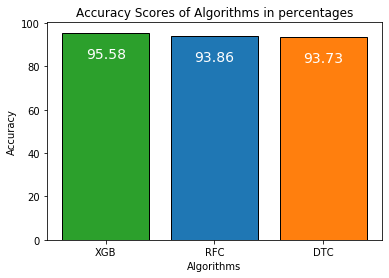

,Model,CV_Score,HO_Out-Of-Sample_Score,HO_In-Sample_Score
0,XGBoost Classification,0.9558,0.9479,0.9854
1,Random forest Classification,0.9386,0.9419,1.0000
2,Decision Trees Classifier,0.9373,0.9452,0.9467


In [72]:
scores = {'RFC' : score_RFC.mean()*100,
                   'DTC': score_DTC.mean()*100, 
                   'XGB' : score_xgb.mean()*100}
scores_sorted = {k: v for k, v in sorted(scores.items(), reverse=True, key=lambda item: item[1])}

scores_sorted
keys = scores_sorted.keys()
values = scores_sorted.values()

formatted_values = []
for item in values :
    formatted_values.append("%.2f"%item)


barplot = plt.bar(keys, values, edgecolor='black', color=['C2', 'C0', 'C1'])
plt.title("Accuracy Scores of Algorithms in percentages")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
for x,y,z in zip(keys,values,formatted_values):

    label = z

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center 
                 color='w', size=14)

plt.show()

scores_df.head(3)

## Evaluation of Scores

There are two models who are predicting with high accuracy namely: XGBoost and Random Forest. I will use both these in the Loan officer app of step 9. I will also print both of the generaterd predicted values to a CSV since both of these algorithms seem to be quite accuracte. Note that since I cleaned my test data, the final prediction count is 999 and not 1000, for easy evaluation I will also export my test data after cleaning. 

## Exporting Test Data

In [73]:
test.to_csv('test_clean.csv',index=False)

## Exporting Predictions

In [74]:
model_xgb.fit(train, y_train) #Train on Full Train Data
xgb_pred = model_xgb.predict(test) #Predict on Test
xgb_pred_df = pd.DataFrame(xgb_pred)
xgb_pred_df.to_csv('xgb_classifier_pred.csv',index=False)

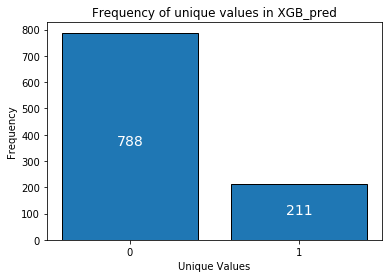

In [75]:
c = list(xgb_pred.astype("int"))
name = str(c).split()

c = collections.Counter(c)
c = sorted(c.items())
xgb_pred_num = [i[0] for i in c]
xgb_pred_names = [name[i[0]-1] for i in c]
freq = [i[1] for i in c]

f, ax = plt.subplots()

plt.bar(xgb_pred_num, freq, edgecolor='black')
plt.title("Frequency of unique values in XGB_pred")
plt.xlabel("Unique Values")
plt.ylabel("Frequency")
for x,y in zip(xgb_pred_num,freq):

    label = y

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,(-y/7)), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center 
                 color='w', size=14)
   
ax.set_xticks(range(0, 2))
ax.set_xticklabels(range(0,2))

plt.show()

In [76]:
model_RFC.fit(train, y_train) #Train on Full Train Data
RFC_pred = model_RFC.predict(test) #Predict on Test
RFC_pred_df = pd.DataFrame(RFC_pred)
RFC_pred_df.to_csv('RFC_classifier_pred.csv',index=False)

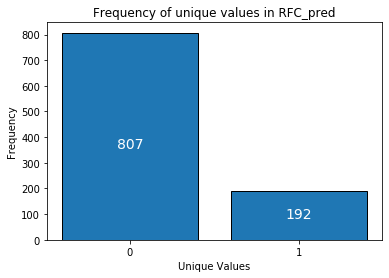

In [77]:
c = list(RFC_pred.astype("int"))
name = str(c).split()

c = collections.Counter(c)
c = sorted(c.items())
RFC_pred_num = [i[0] for i in c]
RFC_pred_names = [name[i[0]-1] for i in c]
freq = [i[1] for i in c]

f, ax = plt.subplots()

plt.bar(RFC_pred_num, freq, edgecolor='black')
plt.title("Frequency of unique values in RFC_pred")
plt.xlabel("Unique Values")
plt.ylabel("Frequency")
for x,y in zip(RFC_pred_num,freq):

    label = y

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,(-y/7)), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center 
                 color='w', size=14)
    
ax.set_xticks(range(0, 2))
ax.set_xticklabels(range(0,2))

plt.show()

##### Stop Code Timing

In [78]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1642.0493857860565 seconds ---
